In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2 

In [8]:
import os
import datajoint as dj
dj.config['database.host'] = os.environ['DJ_HOST']
dj.config['database.user'] = os.environ['DJ_USER']
dj.config['database.password'] = os.environ['DJ_PASS']
dj.config['enable_python_native_blobs'] = True
dj.config['display.limit'] = 200

name = "realdata"
dj.config['schema_name'] = f"konstantin_nnsysident_{name}"

In [3]:
import torch
import numpy as np
import pickle 
import string
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)
import matplotlib.pyplot as plt
import matplotlib
import re
import seaborn as sns

import nnfabrik
from nnfabrik.main import *
from nnfabrik import builder
from nnfabrik.utility.hypersearch import Bayesian

from nnsysident.tables.experiments import *
from nnsysident.tables.bayesian import *
from nnsysident.datasets.mouse_loaders import static_shared_loaders
from nnsysident.datasets.mouse_loaders import static_loaders
from nnsysident.datasets.mouse_loaders import static_loader
from nnsysident.tables.scoring import OracleScore, OracleScoreTransfer

Connecting konstantin@sinzlab.chlkmukhxp6i.eu-central-1.rds.amazonaws.com:3306
Schema name: konstantin_nnsysident_realdata


In [4]:
def find_number(text, c):
    number_list = re.findall(r'%s(\d+)' % c, text)
    if len(number_list) == 0:
        number = None
    elif len(number_list) == 1:
        number = int(number_list[0])
    else:
        raise ValueError('More than one number found..') 
    return number

def get_transfer(transfer_hashes):
    # prepare the Transfer table in a way that all the info about the transferred model is in the DataFrame. Just pd.merge (on transfer_fn and transfer_hash)
    # it then with the model that the transferred model was used for. 
    
    transfer = pd.DataFrame((Transfer & 'transfer_hash in {}'.format(tuple(transfer_hashes))).fetch())
    transfer = pd.concat([transfer, transfer['transfer_config'].apply(pd.Series)], axis = 1).drop('transfer_config', axis = 1)

    restriction = transfer.rename(columns = {'t_model_hash': 'model_hash', 't_dataset_hash': 'dataset_hash', 't_trainer_hash': 'trainer_hash'})            
    restriction = restriction[['model_hash', 'dataset_hash', 'trainer_hash']].to_dict('records')

    tm = pd.DataFrame((TrainedModel * Dataset * Seed & restriction).fetch()).rename(
        columns = {'model_hash': 't_model_hash', 'trainer_hash': 't_trainer_hash', 'dataset_hash': 't_dataset_hash'})               
    tm = tm.sort_values('score', ascending=False).drop_duplicates(['t_model_hash', 't_trainer_hash', 't_dataset_hash'])

    transfer = pd.merge(transfer, tm, how='inner', on=['t_model_hash', 't_trainer_hash', 't_dataset_hash'])
    transfer = pd.concat([transfer, transfer['dataset_config'].apply(pd.Series)], axis = 1).drop('dataset_config', axis = 1)
    transfer.columns = ['t_' + col if col[:2] != 't_' and col[:8] != 'transfer'  else col for col in transfer.columns]
    transfer = transfer.sort_values(['t_multi_match_n', 't_image_n', 't_multi_match_base_seed', 't_image_base_seed'])
    return transfer

### Seed comparison (model, neuron, image)

In [ ]:
experiment_name = 'Real, Direct, se2d_fullgaussian2d, 4-set, seed comparison'

data = pd.DataFrame((TrainedModel * Dataset * Experiments.Restrictions & 'experiment_name="{}"'.format(experiment_name)).fetch())
data = pd.concat([data, data['dataset_config'].apply(pd.Series)], axis = 1)
data = data[['seed', 'multi_match_base_seed', 'image_base_seed', 'score']]

seed_model = data.loc[(data['multi_match_base_seed'] == 1) & (data['image_base_seed'] == 5)].copy()
seed_neuron = data.loc[(data['seed'] == 1) & (data['image_base_seed'] == 1)].copy()
seed_image = data.loc[(data['multi_match_base_seed'] == 1) & (data['seed'] == 1)].copy()

seed_model['Seed type'] = 'Model seed'
seed_neuron['Seed type'] = 'Neuron seed'
seed_image['Seed type'] = 'Image seed'

seed_data = pd.concat([seed_model, seed_neuron, seed_image])

In [ ]:
title = 'Seed comparison'
with sns.plotting_context('paper'), sns.color_palette('colorblind'), sns.axes_style('ticks'):
    fig, ax = plt.subplots(dpi=150)
    sns.swarmplot(x="Seed type", y="score",  size=10, data=seed_data, ax=ax)
    sns.despine(trim=True)
    ax.set_xlabel('')
    ax.set_ylabel('validation correlation')
    #fig.savefig(title.title().replace(" ", "") + '.png', dpi=150)

### Regularization 

In [ ]:
model_fn = 'nnsysident.models.models.se2d_fullgaussian2d'
#model_fn = 'nnsysident.models.models.se2d_spatialxfeaturelinear'
title = 'Regularization vs Images - ' + model_fn.split('.')[-1][5:]

model = pd.DataFrame((Model & 'model_fn="{}"'.format(model_fn)).fetch())
for arg in ['multi_match_n', 'image_n']:
    model[arg] = [int(find_number(row.model_comment, arg + '=')[0]) for loc, row in model.iterrows()]
model = pd.concat([model, model['model_config'].apply(pd.Series)], axis = 1).drop('model_config', axis = 1)
#model = model.loc[model['multi_match_n'].isin([50, 100, 1000])]
#model = model.loc[model['image_n'] != 50]
model.sort_values(['multi_match_n', 'image_n'], inplace=True)
model.rename(columns={"multi_match_n": "# neurons", "image_n": "# images"}, inplace=True)

with sns.plotting_context('paper'), sns.color_palette('colorblind'), sns.axes_style('ticks'):
    fig, ax = plt.subplots(dpi=150)
    sns.pointplot('# images', "gamma_readout", hue='# neurons', data=model, ax=ax)
    sns.despine(trim=True)
    ax.set_ylabel('readout regularization')
    #plt.legend(loc='lower left')
    #fig.savefig(title.title().replace(" ", "") + '.png', dpi=150)

# Directly trained

In [ ]:
# experiment_names = ['Real, Direct, se2d_fullgaussian2d, 4-set', 'Real, Direct, se2d_spatialxfeaturelinear, 4-set']

# # Fetch data
# data = pd.DataFrame()
# for experiment_name in experiment_names:
#     data_ = pd.DataFrame((TrainedModel * Dataset * Model * Trainer * Seed * OracleScore *Experiments.Restrictions & 'experiment_name="{}"'.format(experiment_name)).fetch())
#     data = pd.concat([data, data_])
    
# # Filter out relevant data
# data = pd.concat([data, data['dataset_config'].apply(pd.Series)], axis = 1).drop('dataset_config', axis = 1)
# data = pd.concat([data, data['model_config'].apply(pd.Series)], axis = 1).drop('model_config', axis = 1)
# data['readout'] = [row.model_fn.split('.')[-1][5:] for loc, row in data.iterrows()]

# # Filter out best performing models over model seeds
# data = data.sort_values('score', ascending=False).drop_duplicates(['readout', 
#                                                                    'multi_match_n',
#                                                                    'image_n', 
#                                                                    'multi_match_base_seed',
#                                                                    'image_base_seed']).sort_values(['readout', 'multi_match_n', 'image_n'])
# data['image_n'] = data['image_n'] * 4
# data = data.rename(columns = {'multi_match_n': '# neurons', 'image_n': "# images"})

In [ ]:
# readout = "spatialxfeaturelinear"
# scoring_measure = "fraction_oracle"
# x_hue = ['# neurons', '# images']

# title = 'Directly trained, real data, {}, {}'.format(readout, x_hue[0])

# data_readout = data.loc[data['readout'] == readout]
# hues = np.unique(data_readout[x_hue[1]])
    
# with sns.plotting_context('paper'), sns.color_palette('colorblind'), sns.axes_style('ticks'):
#     fig, ax = plt.subplots(dpi=150)
#     sns.pointplot(x_hue[0], scoring_measure, hue=x_hue[1], data=data_readout, 
#                 hue_order=hues, ax=ax)

#     sns.despine(trim=True)
#     ax.set_ylabel(scoring_measure.replace('_', ' ')) 
#     #ax.set_xlabel('# images') 
#     ax.legend(loc='lower right', bbox_to_anchor=(0.99, 0.05), ncol=1, frameon=False, title=x_hue[1])
#     plt.title(title)
    
#     fig.savefig(title.title().replace(" ", "").replace(",", "-") + '.png', dpi=150)

In [ ]:
experiment_names = ['Real, Direct, se2d_fullgaussian2d, 4-set', 'Real, Direct, se2d_spatialxfeaturelinear, 4-set']

# Fetch data
data = pd.DataFrame()
for experiment_name in experiment_names:
    data_ = pd.DataFrame((TrainedModel * Dataset * Model * Trainer * Seed * OracleScore *Experiments.Restrictions & 'experiment_name="{}"'.format(experiment_name)).fetch())
    data = pd.concat([data, data_])
    
# Filter out relevant data
data = pd.concat([data, data['dataset_config'].apply(pd.Series)], axis = 1).drop('dataset_config', axis = 1)
data = pd.concat([data, data['model_config'].apply(pd.Series)], axis = 1).drop('model_config', axis = 1)
data['Readout'] = [row.model_fn.split('.')[-1][5:] for loc, row in data.iterrows()]

# Filter out best performing models over model seeds
data = data.sort_values('score', ascending=False).drop_duplicates(['Readout', 
                                                                   'multi_match_n',
                                                                   'image_n', 
                                                                   'multi_match_base_seed',
                                                                   'image_base_seed']).sort_values(['Readout', 'multi_match_n', 'image_n'])
data['image_n'] = data['image_n'] * 4
data = data.rename(columns = {'multi_match_n': '# neurons', 'image_n': "# images"})
data = data.loc[data['# neurons'].isin([50, 500, 3625])]
data.replace({'Readout': {'spatialxfeaturelinear':'factorized ', 'fullgaussian2d':'gaussian', 'pointpooled':'Point-Pooled'}}, inplace=True)

In [ ]:
scoring_measure = "fraction_oracle"
palette = [col for i, col in enumerate(sns.color_palette('bright')) if i in (5,8) ]

title = 'Direct training - readout comparison'
    
paper_rc = {'lines.linewidth': 4, 'lines.markersize': 10}  
with sns.plotting_context('paper', rc=paper_rc, font_scale=2.15), sns.color_palette('bright'), sns.axes_style('ticks'):     
    
    g = sns.relplot(x="# images", 
                    y=scoring_measure,
                    hue="Readout", 
                    style="# neurons",
                    kind="line",
                    data=data,
                    markers=True,
                    height=7,
                    aspect=0.9,
                    palette=palette) 
    
    ax = g.axes[0, 0]
    
    ax.set_xticks(np.unique(data['# images'])[[0, 3, 4, 5]])
    ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax.set_xlabel("# images", fontsize=28)
    ax.set_ylabel(scoring_measure.replace('_', ' ').capitalize(), fontsize=28)
    ax.tick_params(labelsize=25)
    ax.set_yticks([.1, .3, .5, .7, .9])
    ax.set_yticks([.1, .2, .3, .4, .5, .6, .7, .8, .9], minor=True)
    ax.yaxis.grid(which='major')
    ax.yaxis.grid(which='minor')
    sns.despine(trim=True)
    plt.tight_layout()
    
    idx = [4, 5, 6, 1, 2]
    h, l = ax.get_legend_handles_labels()
    h = [h[i] for i in idx]
    l = [l[i].capitalize() for i in idx]
    g._legend.remove()
    g.fig.legend(h,l, ncol=2, frameon=False, bbox_to_anchor=(0.45, 0.25, 0.5, 0.2), fontsize=22)
    
    # add title to the legend
    ax.text(4900, .4, "# neurons", fontsize=25, )
    ax.text(12500, .4, "Readout", fontsize=25)
    
    g.fig.savefig(title.title().replace(" ", "").replace(",", "-") + '.pdf', dpi=150, bbox_inches='tight')

In [ ]:
data.loc[(data['# images'] == 17596) & (data['# neurons'] == 3625) & (data['Readout'] == 'factorized ')].fraction_oracle.std()

---

### Real data condition comparison

In [ ]:
# direct data
experiment_names = ['Real, Direct, se2d_fullgaussian2d, 4-set, last 972 neurons', 'Real, Direct, se2d_spatialxfeaturelinear, 4-set, last 972 neurons']
# Fetch data
data = pd.DataFrame()
for experiment_name in experiment_names:
    data_ = pd.DataFrame((TrainedModel * Dataset * Model * Trainer * Seed * OracleScore *Experiments.Restrictions & 'experiment_name="{}"'.format(experiment_name)).fetch())
    data = pd.concat([data, data_])
    
# Filter out relevant data
data = pd.concat([data, data['dataset_config'].apply(pd.Series)], axis = 1).drop('dataset_config', axis = 1)
data = pd.concat([data, data['model_config'].apply(pd.Series)], axis = 1).drop('model_config', axis = 1)
data['Readout'] = [row.model_fn.split('.')[-1][5:] for loc, row in data.iterrows()]

# Filter out best performing models over model seeds
data = data.sort_values('score', ascending=False).drop_duplicates(['Readout', 
                                                                   'multi_match_n',
                                                                   'image_n', 
                                                                   'multi_match_base_seed',
                                                                   'image_base_seed']).sort_values(['Readout', 'multi_match_n', 'image_n'])
data['image_n'] = data['image_n'] * 4
data = data.rename(columns = {'multi_match_n': '# neurons', 'image_n': "# images"})
data = data.loc[data['# neurons'] == 972]
data.replace({'Readout': {'spatialxfeaturelinear':'Factorized readout ', 'fullgaussian2d':'Gaussian readout', 'pointpooled':'Point-Pooled'}}, inplace=True)
direct_data = data.copy()
direct_data['Condition'] = "direct"


# full readout data
data = pd.DataFrame()
for experiment_name in ["Real, core_transfer (sameNI), se2d_fullgaussian2d, 4-set -> 4-set, last 972 neurons", 
                        "Real, core_transfer (sameNI), se2d_spatialxfeaturelinear, 4-set -> 4-set, last 972 neurons"]:
    
    data_ = pd.DataFrame((TrainedModelTransfer * Dataset * Model * Trainer * Seed * Transfer.proj() * OracleScoreTransfer * ExperimentsTransfer.Restrictions 
                          & 'experiment_name="{}"'.format(experiment_name)).fetch())
    transfer_hashes = list(data_.transfer_hash)
    transfer_ = get_transfer(transfer_hashes)
    data_ = pd.merge(data_, transfer_, how='inner', on=['transfer_hash', 'transfer_fn'])
    data = pd.concat([data, data_])
data['Readout'] = [row.model_fn.split('.')[-1][5:] for loc, row in data.iterrows()]
data['t_image_n'] = data['t_image_n'] * 4
data = data.rename(columns = {'t_multi_match_n': '# neurons', 't_image_n': "# images"})
data = data.loc[data['# neurons'] == 1000]
data.replace({'Readout': {'spatialxfeaturelinear':'Factorized readout ', 'fullgaussian2d':'Gaussian readout', 'pointpooled':'Point-Pooled'}}, inplace=True)
full_readout_data = data.copy()
full_readout_data['Condition'] = "diff-core/best-readout"


# full core data
data = pd.DataFrame()
for experiment_name in ["Real, core_transfer (best), se2d_fullgaussian2d, 4-set -> 4-set", 
                        "Real, core_transfer (best), se2d_spatialxfeaturelinear, 4-set -> 4-set"]:
    
    data_ = pd.DataFrame((TrainedModelTransfer * Dataset * Model * Trainer * Seed * Transfer.proj() * OracleScoreTransfer * ExperimentsTransfer.Restrictions 
                          & 'experiment_name="{}"'.format(experiment_name)).fetch())
    transfer_hashes = list(data_.transfer_hash)
    transfer_ = get_transfer(transfer_hashes)
    data_ = pd.merge(data_, transfer_, how='inner', on=['transfer_hash', 'transfer_fn'])
    data = pd.concat([data, data_])
data['Readout'] = [row.model_fn.split('.')[-1][5:] for loc, row in data.iterrows()]
data = pd.concat([data, data['dataset_config'].apply(pd.Series)], axis = 1)
data['image_n'] = data['image_n'] * 4
data = data.rename(columns = {'multi_match_n': '# neurons', 'image_n': "# images"})
data = data.loc[data['# neurons'] == 972]
data.replace({'Readout': {'spatialxfeaturelinear':'Factorized readout ', 'fullgaussian2d':'Gaussian readout', 'pointpooled':'Point-Pooled'}}, inplace=True)
full_core_data = data.copy()
full_core_data['Condition'] = "best-core/diff-readout"


data = pd.concat([direct_data, full_readout_data, full_core_data])

In [ ]:
data.loc[(data['Condition'] == 'diff-core/best-readout') & 
         (data['# images'] == 4000) & 
         (data['Readout'] == 'Gaussian readout')].sort_values('fraction_oracle', ascending=False).fraction_oracle.std()

In [ ]:
np.unique(data['# images'])

In [ ]:
title = 'condition comparison'
scoring_measure = "fraction_oracle" 
sns.set_context("paper")        
col_order = ['Factorized readout ', 'Gaussian readout']
palette = [col for i, col in enumerate(sns.color_palette('bright')) if i in (5,6,8) ]


paper_rc = {'lines.linewidth': 2, 'lines.markersize': 10}  
with sns.plotting_context('paper', rc=paper_rc, font_scale=2.5), sns.axes_style('ticks'):        
    g = sns.relplot(x="# images", 
                    y=scoring_measure,
                    hue="Condition", 
                    col="Readout",
                    col_order=col_order,
                    kind="line",
                    marker="o",
                    data=data,
                    palette=palette, 
                    height=5, 
                    aspect=.9)          
       
    g.axes[0,0].set_ylabel(scoring_measure.replace('_', ' '))
    g.axes[0,0].set_xlabel('# images')
    g.axes[0,1].set_xlabel('# images')
    g._legend.texts[0].set_text("")
    g._legend.set_bbox_to_anchor((.84, .39, .1, .1))
    
    for h in g._legend.legendHandles[1:]:
        h.set_linewidth(4)
        
    for label in g._legend.texts:
            label.set_size(20)
    
    for i, ax in enumerate(g.axes.flatten()): 
        ax.set_title(ax.get_title()[10:])   
        ax.yaxis.grid(True)
        ax.set_xticks(np.unique(data['# images'])[[0, 3, 4, 5]])
        ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
        ax.text(0.5, 1.05, ax.get_title(),
                horizontalalignment='center',
                fontsize=26,
                transform=ax.transAxes)
        ax.set_title("")
        
        ax.text(-0.1, 1.09, string.ascii_uppercase[i], transform=ax.transAxes, size=30, weight='bold') 
        
        if i > 0:
            ax.set(xlabel="")
        else:
            ax.set_xlabel("# images", fontsize=24)
            ax.set_ylabel("Fraction oracle", fontsize=24)
    
    sns.despine(trim=True)
    plt.tight_layout()
    g.fig.savefig(title + '.pdf', dpi=150, bbox_inches='tight')

# core-transfer (sameNI)

In [ ]:
# core-transfer (sameNI)
data = pd.DataFrame()
for experiment_name in ["Real, core_transfer (sameNI), se2d_fullgaussian2d, 4-set -> 4-set", 
                        "Real, core_transfer (sameNI), se2d_spatialxfeaturelinear, 4-set -> 4-set"]:
    
    data_ = pd.DataFrame((TrainedModelTransfer * Dataset * Model * Trainer * Seed * Transfer.proj() * OracleScoreTransfer * ExperimentsTransfer.Restrictions 
                          & 'experiment_name="{}"'.format(experiment_name)).fetch())
    transfer_hashes = list(data_.transfer_hash)
    transfer_ = get_transfer(transfer_hashes)
    data_ = pd.merge(data_, transfer_, how='inner', on=['transfer_hash', 'transfer_fn'])
    data = pd.concat([data, data_])
data['readout'] = [row.model_fn.split('.')[-1][5:] for loc, row in data.iterrows()]
data['t_image_n'] = data['t_image_n'] * 4
data = data.rename(columns = {'t_multi_match_n': '# neurons', 't_image_n': "# images"})

In [ ]:
readout = "spatialxfeaturelinear"
scoring_measure = "fraction_oracle"
x_hue = ['# neurons', '# images']

title = 'Core transfer, same #N and #I, {}, {}'.format(readout, x_hue[0])

data_readout = data.loc[data['readout'] == readout]
hues = np.unique(data_readout[x_hue[1]])


with sns.plotting_context('paper'), sns.color_palette('colorblind'), sns.axes_style('ticks'):
    fig, ax = plt.subplots(dpi=150)
    sns.pointplot(x_hue[0], scoring_measure, hue=x_hue[1], data=data_readout, 
                hue_order=hues, ax=ax)

    sns.despine(trim=True)
    ax.set_ylabel(scoring_measure.replace('_', ' ')) 
    #ax.set_xlabel('# images') 
    ax.legend(loc='lower right', bbox_to_anchor=(0.99, 0.05), ncol=1, frameon=False, title=x_hue[1])
    plt.title(title)
    
    #fig.savefig(title.title().replace(" ", "").replace(",", "-") + '.png', dpi=150)    

# core transfer (best)

In [ ]:
# core-transfer (best)
data = pd.DataFrame()
for experiment_name in ["Real, core_transfer (best), se2d_fullgaussian2d, 4-set -> 4-set", 
                        "Real, core_transfer (best from GAUSSIAN!), se2d_spatialxfeaturelinear, 4-set -> 4-set"]:
    #"Real, core_transfer (best), se2d_spatialxfeaturelinear, 4-set -> 4-set"
    data_ = pd.DataFrame((TrainedModelTransfer * Dataset * Model * Trainer * Seed * Transfer.proj() * OracleScoreTransfer * ExperimentsTransfer.Restrictions 
                          & 'experiment_name="{}"'.format(experiment_name)).fetch())
    transfer_hashes = list(data_.transfer_hash)
    transfer_ = get_transfer(transfer_hashes)
    data_ = pd.merge(data_, transfer_, how='inner', on=['transfer_hash', 'transfer_fn'])
    data = pd.concat([data, data_])
data['readout'] = [row.model_fn.split('.')[-1][5:] for loc, row in data.iterrows()]
data = pd.concat([data, data['dataset_config'].apply(pd.Series)], axis = 1)
data['image_n'] = data['image_n'] * 4
data = data.rename(columns = {'multi_match_n': '# neurons', 'image_n': "# images"})

In [ ]:
scoring_measure = "fraction_oracle"

title = 'Core transfer, best respective core'

hues = np.unique(data.readout)


with sns.plotting_context('paper'), sns.color_palette('colorblind'), sns.axes_style('ticks'):
    fig, ax = plt.subplots(dpi=150)
    sns.pointplot('# images', scoring_measure, hue='readout', data=data, 
                hue_order=hues, ax=ax)

    sns.despine(trim=True)
    ax.set_ylabel(scoring_measure.replace('_', ' ')) 
    ax.set_xlabel('# images') 
    ax.legend(loc='lower right', bbox_to_anchor=(0.99, 0.05), ncol=1, frameon=False, title='readouts')
    plt.title(title)
    
    fig.savefig(title.title().replace(" ", "").replace(",", "-") + ' - all gaussian core' + '.png', dpi=150)        

# core transfer (animal)

In [141]:
# core-transfer (best)

experiment_names = ["Real, Direct, se2d_fullgaussian2d, 20457-5-9", 
                    "Real, direct (RANDOM fixed core 128), se2d_fullgaussian2d, 20457-5-9",
                    "Real, direct (RANDOM fixed core 64), se2d_fullgaussian2d, 20457-5-9",
                    "Real, direkt (VGG16 fixed core), taskdriven_fullgaussian2d, VGG16 -> 20457-5-9",
                    "Real, Direct, taskdriven_fullgaussian2d (random VGG16 fixed core), 20457-5-9"]
new_names = ["direct", "random core 128", "random core 64", 'VGG16', 'random VGG16 ']

data = pd.DataFrame()
for experiment_name, new_name in zip(experiment_names, new_names):
    
    data_ = pd.DataFrame((TrainedModel * Dataset * Model * Trainer * Seed * OracleScore * Experiments.Restrictions 
                         & 'experiment_name="{}"'.format(experiment_name)).fetch())
    data_['transfer_description'] = new_name
    data = pd.concat([data, data_])
    
# Filter out best performing models over model seeds
data = pd.concat([data, data['dataset_config'].apply(pd.Series)], axis = 1)
data = data.sort_values('score', ascending=False).drop_duplicates(['transfer_description', 
                                                                   'neuron_n',
                                                                   'image_n', 
                                                                   'neuron_base_seed',
                                                                   'image_base_seed']).sort_values(['transfer_description', 'neuron_n', 'image_n'])


experiment_names = ["Real, core_transfer (animal), se2d_fullgaussian2d, 11-set -> 20457-5-9", 
                    "Real, core_transfer (animal), se2d_fullgaussian2d, 4-set -> 20457-5-9",
                    "Real, core_transfer (animal), se2d_fullgaussian2d, 20505-6-1 -> 20457-5-9",
                    "Real, core_transfer (animal) NO CORTEX, se2d_fullgaussian2d, 11-set -> 20457-5-9",
                    "Real, core_transfer (animal), se2d_fullgaussian2d, 4 DiffAnimalsDiffImages -> 20457-5-9"]
# "Real, core_transfer (animal), se2d_fullgaussian2d, 4 DiffAnimalsSameImages -> 20457-5-9" -> autistic mouse

new_names = ['11-S', '4-S: matched', "1-S", "11-S: no cortex", '4-S: diff animals ']

for experiment_name, new_name in zip(experiment_names, new_names):
    
    data_ = pd.DataFrame((TrainedModelTransfer * Dataset * Model * Trainer * Seed * Transfer.proj() * OracleScoreTransfer * ExperimentsTransfer.Restrictions 
                          & 'experiment_name="{}"'.format(experiment_name)).fetch())
    data_ = pd.concat([data_, data_['dataset_config'].apply(pd.Series)], axis = 1)
    data_['transfer_description'] = new_name
    data = pd.concat([data, data_])
    
data = data.rename(columns = {'neuron_n': '# neurons', 'image_n': "# images"})
# data.replace({"transfer_description": {'Direct': 'direct', 
#                                        'direct (RANDOM fixed core)': 'random', 
#                                        'direkt (VGG16 fixed core)': 'VGG16'}}, inplace=True)

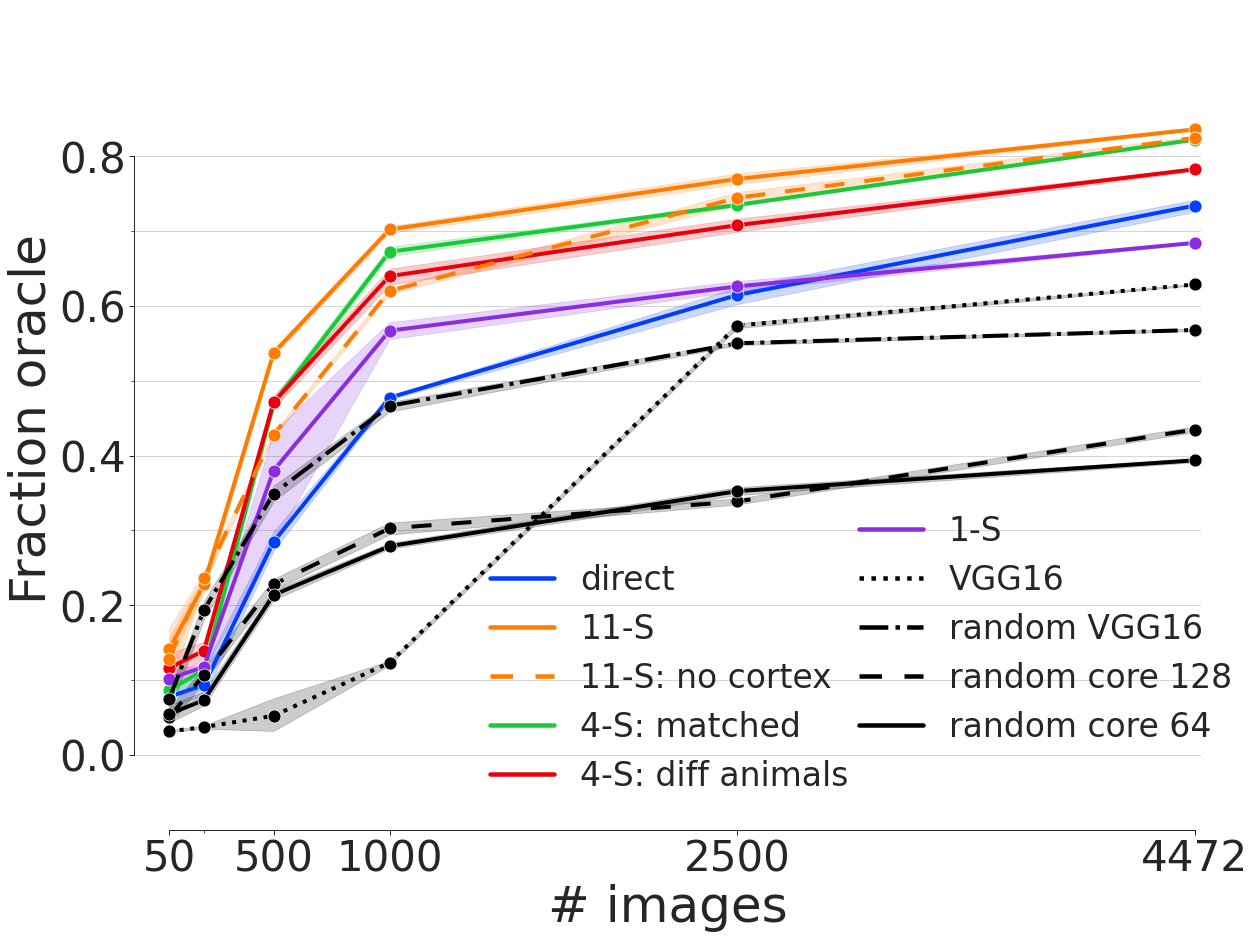

In [163]:
from pylab import Rectangle

palette = sns.color_palette('bright')[:2] + sns.color_palette('bright')[1:5]
palette += [(0., 0., 0.), (0.,0.,0.), (0.,0.,0.), (0., 0., 0.)]
scoring_measure = "fraction_oracle"
color = 'green'
title = 'animal transfer'
hues = ['direct', 
        '11-S', 
        '11-S: no cortex',
        '4-S: matched', 
        '4-S: diff animals ', 
        '1-S', 
        'VGG16', 
        'random VGG16 ',
        'random core 128',
        'random core 64'] 

paper_rc = {'lines.linewidth': 4, 'lines.markersize': 13} #, 'axes.linewidth': 2  
with sns.plotting_context('paper', rc=paper_rc, font_scale=4.), sns.axes_style('ticks'):      
    g = sns.relplot(x="# images", 
                    y=scoring_measure,
                    hue="transfer_description", 
                    kind="line",
                    hue_order=hues,
                    data=data,
                    marker="o",
                    height=14,
                    aspect=.84,
                    palette=palette,
                   ) 
    ax = g.axes[0, 0]
    g.axes[0,0].set_ylabel(scoring_measure.replace('_', ' '))
    
    
    h, l = ax.get_legend_handles_labels()
#     l = l[1:]
#     h = h[]
    g._legend.remove()
    leg = g.fig.legend(h, l, ncol=2, frameon=False, bbox_to_anchor=(0.45, 0.25, 0.5, 0.2), fontsize=32, columnspacing=.01)
    
    for i, style in zip([2, 6, 7, 8], [(0,(5,5)),':', '-.', (0,(5,5))]):
        g.axes[0,0].lines[i].set_linestyle(style)
        leg.legendHandles[i+1].set_linestyle(style)
    
#     leg = g._legend
    leg.texts[0].set_text("")
#     leg.set_bbox_to_anchor([1.0, 0.4])
    g.axes[0,0].lines[2].set_zorder(100)
    
    for label in leg.texts:
        label.set_size(33)
        
    for h in leg.legendHandles[1:]:
        h.set_linewidth(4.5)
    
    ax = g.axes[0, 0]
    ax.set_ylim(-.1, 1)
    ax.set_xlim(-100, 4500)
    ax.set_yticks([.1, .2, .3, .4, .5, .6, .7, .8], minor=True)
    ax.yaxis.grid(which='major')
    ax.yaxis.grid(which='minor')
    ax.set_xticks(np.unique(data['# images'])[[0, 2, 3, 4, 5]])
    ax.set_xticks(np.unique(data['# images']), minor=True)
    ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax.set_xlabel("# images", fontsize=50)
    ax.set_ylabel("Fraction oracle", fontsize=50)
    ax.tick_params(labelsize=42)
#     ax.tick_params('x', rotation=-30)
#     for label in ax.xaxis.get_ticklabels():
#         label.set_horizontalalignment('left')
    
    
    sns.despine(trim=True)
    name = title.title().replace(" ", "").replace(",", "-")
    g.fig.tight_layout()
    g.fig.savefig(name + '.pdf', dpi=150,  bbox_inches='tight')

### Best core - Comparison of share_features and cortex 

In [ ]:
# full core data
data = pd.DataFrame()

conditions = ['share feat, cortex', '~share feat, cortex', 'share feat, ~cortex', '~share feat, ~cortex']
for experiment_name, condition in zip(["Real, core_transfer (best), se2d_fullgaussian2d, 4-set -> 4-set", 
                        "Real, core_transfer (best) SHARE_FEAUTURES=False, se2d_fullgaussian2d, 4-set -> 4-set",
                        "Real, core_transfer (best) NO CORTEX, se2d_fullgaussian2d, 4-set -> 4-set",
                        "Real, core_transfer (best) SHARE_FEAUTURES=False and NO CORTEX, se2d_fullgaussian2d, 4-set -> 4-set"], conditions):
    
    data_ = pd.DataFrame((TrainedModelTransfer * Dataset * Model * Trainer * Seed * Transfer.proj() * OracleScoreTransfer * ExperimentsTransfer.Restrictions 
                          & 'experiment_name="{}"'.format(experiment_name)).fetch())
    transfer_hashes = list(data_.transfer_hash)
    transfer_ = get_transfer(transfer_hashes)
    data_ = pd.merge(data_, transfer_, how='inner', on=['transfer_hash', 'transfer_fn'])
    data_['condition'] = condition
    data = pd.concat([data, data_])
    
data = pd.concat([data, data['dataset_config'].apply(pd.Series)], axis = 1)
data['image_n'] = data['image_n'] * 4
data = data.rename(columns = {'multi_match_n': '# neurons', 'image_n': "# images"})
data = data.loc[data['# neurons'] == 972]

In [ ]:
scoring_measure = "fraction_oracle"
palette = [col for i, col in enumerate(sns.color_palette('bright')) if i in (5,6,7,8) ]

title = 'Direct training - readout comparison'
    
paper_rc = {'lines.linewidth': 4, 'lines.markersize': 10}  
with sns.plotting_context('paper', rc=paper_rc, font_scale=2.15), sns.color_palette('bright'), sns.axes_style('ticks'):     
    
    g = sns.relplot(x="# images", 
                    y=scoring_measure,
                    hue="condition", 
                    kind="line",
                    data=data,
                    markers=True,
                    height=7,
                    aspect=0.9,
                    palette=palette) 
    
    ax = g.axes[0, 0]
    
    ax.set_xticks(np.unique(data['# images'])[[0, 3, 4, 5]])
    ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax.set_xlabel("# images", fontsize=28)
    ax.set_ylabel(scoring_measure.replace('_', ' ').capitalize(), fontsize=28)
    ax.tick_params(labelsize=25)
    ax.set_yticks([.1, .3, .5, .7, .9])
    ax.set_yticks([.1, .2, .3, .4, .5, .6, .7, .8, .9], minor=True)
    ax.yaxis.grid(which='major')
    ax.yaxis.grid(which='minor')
    sns.despine(trim=True)
    plt.tight_layout()
    g._legend.set_bbox_to_anchor((0.35, 0.35, 0.5, 0.2))
    plt.title('best-core/diff-readout: gaussian (old version)')
#     idx = [4, 5, 6, 1, 2]
#     h, l = ax.get_legend_handles_labels()
#     h = [h[i] for i in idx]
#     l = [l[i].capitalize() for i in idx]
#     g._legend.remove()
#     g.fig.legend(h,l, ncol=2, frameon=False, bbox_to_anchor=(0.45, 0.25, 0.5, 0.2), fontsize=22)
    
    # add title to the legend
#     ax.text(4900, .4, "# neurons", fontsize=25, )
#     ax.text(12500, .4, "Readout", fontsize=25)
    
    #g.fig.savefig('share_feature_and_cortex_comparison' + '.pdf', dpi=150, bbox_inches='tight')